# Preparing for analysis

## Importing Library

In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from scipy.optimize import minimize
import pytz
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import seaborn as sns
# from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa.api as smt
from copy import deepcopy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings
warnings.filterwarnings("ignore")
import statsmodels.tools.eval_measures
import scipy 
from scipy import stats
import time
from matplotlib.dates import DateFormatter
from matplotlib.dates import YearLocator, DateFormatter
from statsmodels.tsa.api import VAR

## Importing Data

In [2]:
df_base = pd.read_excel("./RAW_DATA.xlsx")

In [3]:
df_base

,Date,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX
0,2014-09-21,25.395000,16.200001,457.334015,84.699997,1234.400024,29.158445,49.269161,46.520000,2001.569946,2.600,12.650000
1,2014-09-28,25.264999,16.225000,402.152008,84.669998,1216.800049,29.288090,49.215687,47.060001,1994.290039,2.566,13.690000
2,2014-10-05,25.027500,16.091000,375.467010,85.589996,1217.500000,28.739098,48.048126,46.439999,1977.800049,2.491,15.980000
3,2014-10-12,24.905001,16.110001,330.079010,85.709999,1206.699951,28.788462,47.228165,46.090000,1964.819946,2.425,15.460000
4,2014-10-19,24.952499,15.322500,390.414001,85.430000,1229.300049,26.587503,43.645275,43.650002,1874.739990,2.286,24.639999
...,...,...,...,...,...,...,...,...,...,...,...,...
473,2023-10-15,178.990005,128.259995,27583.677734,106.080002,1849.500000,139.500000,61.900002,329.820007,4335.660156,4.797,17.700001
474,2023-10-22,178.720001,132.550003,28519.466797,106.239998,1921.099976,140.490005,63.349998,332.640015,4373.629883,4.712,17.209999
475,2023-10-29,173.000000,126.559998,33086.234375,105.540001,1976.300049,137.899994,58.490002,329.320007,4217.040039,4.838,20.370001
476,2023-11-05,170.289993,132.710007,34502.363281,106.120003,1996.199951,125.750000,59.419998,337.309998,4166.819824,4.875,19.750000


# Data Analysis

## Functions

[Function]Hist plot

In [50]:
# Function to create a histogram from a specified column in a DataFrame
def create_histogram(dataframe, column_name):
    """
    This function creates a histogram for a specified column from a DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column for which the histogram is to be created.

    Returns:
    A histogram plot for the specified column.
    """
    # Check if the column name exists in the DataFrame
    if column_name not in dataframe.columns:
        raise ValueError(f"The column '{column_name}' does not exist in the DataFrame.")

    # Plot the histogram
    dataframe[column_name].hist()
    plt.title(f"Histogram of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()


# Convert the 'Date' column to datetime and 'Value' to numeric, ignoring errors for conversion
# df = pd.DataFrame(data)
# df['Date'] = pd.to_datetime(df['Date'])
# df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

# Call the function with the example DataFrame and the 'Value' column
# create_histogram(df, 'Value')


[Function] Checking data: Normality

In [59]:
# データが正規分布に従っているかどうかを評価する関数
def evaluate_normality(data):
    # NaN値を削除
    data = data[~np.isnan(data)]
    
    # シャピロ-ウィルク テスト
    shapiro_test = stats.shapiro(data)
    print(f"Shapiro-Wilk Test: statistic={shapiro_test[0]}, p-value={shapiro_test[1]}")

    # アンダーソン-ダーリング テスト
    anderson_test = stats.anderson(data, dist='norm')
    print(f"Anderson-Darling Test: statistic={anderson_test.statistic}, significance_level={anderson_test.significance_level}, critical_values={anderson_test.critical_values}")

    # コルモゴロフ-スミルノフ テスト
    ks_test = stats.kstest(data, 'norm', args=(np.mean(data), np.std(data)))
    print(f"Kolmogorov-Smirnov Test: statistic={ks_test.statistic}, p-value={ks_test.pvalue}")

# サンプルデータを生成（ここでは正規分布を仮定している）
#sample_data = np.random.normal(loc=0, scale=1, size=100)

# データの正規性を評価
#evaluate_normality(sample_data)


[Function]Visualizing Linear data

In [9]:
def plot_stock_prices(title, dataframe, selected_columns, figsize=(20, 6)):
    """
    Plot stock prices from a dataframe.
    
    Parameters:
    - title: str, the title of the plot.
    - dataframe: pd.DataFrame containing date and stock prices.
    - selected_columns: list, the column names of stock prices to be plotted.
    - figsize: tuple, size of the figure to plot.
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Assuming the Date column is always named 'Date'
    for column in selected_columns:
        ax.plot(dataframe.index, dataframe[column], label=column)

    ax.set_title(f'Stock Price over Time({title})')
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend()
    
    # y軸の横の線を点線に設定
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, axis="y")
    # x軸の縦線を消す
    ax.grid(False, axis="x")
    
    # グラフの周りの四角い線を灰色に設定
    for spine in ax.spines.values():
        spine.set_color('gray')
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=12))
    
    plt.style.use('tableau-colorblind10')
    plt.tight_layout()
    plt.show()

# 使用例
# selected_columns = ["Stock1", "Stock2"]
# plot_stock_prices('title', dataframe, selected_columns)

[Function]Making Portofolio

In [4]:
def calculate_efficient_frontier(temp_data, selected):
    # calculate daily and annual returns of the stocks
    returns_monthly = temp_data.pct_change()
    returns_annual = returns_monthly.mean() * 12

    # get daily and covariance of returns of the stock
    cov_monthly = returns_monthly.cov()
    cov_annual = cov_monthly * 12

    # 米国国債のリスクフリーレート
    rf_rate = 0.04849

    # empty lists to store returns, volatility and weights of imaginary portfolios
    port_returns = []
    port_volatility = []
    sharpe_ratio = []
    stock_weights = []

    # set the number of combinations for imaginary portfolios
    num_assets = len(selected)
    num_portfolios = 5000

    np.random.seed(101)

    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_annual)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = (returns - rf_rate) / volatility  # シャープレシオの計算を修正
        sharpe_ratio.append(sharpe)
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)

    portfolio = {'Returns': port_returns,
                'Volatility': port_volatility,
                'Sharpe Ratio': sharpe_ratio}

    for counter, symbol in enumerate(selected):
        portfolio[symbol + ' Weight'] = [Weight[counter] for Weight in stock_weights]

    df = pd.DataFrame(portfolio)
    column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' Weight' for stock in selected]
    df = df[column_order]

    # 最大シャープレシオを持つポートフォリオを探す
    max_sharpe = df['Sharpe Ratio'].max()
    min_volatility = df['Volatility'].min()
    sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
    min_variance_port = df.loc[df['Volatility'] == min_volatility]

    print(sharpe_portfolio.T)
    print(min_variance_port.T)

    df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                    cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
    plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
    plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200)
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Returns')
    plt.title('Efficient Frontier with Tangent Portfolio')
    plt.show()

# 使用例:
# calculate_efficient_frontier(temp_data, selected)

[Funstion]ADF test

In [6]:
def perform_adf_test_on_dataframe(df, alpha=0.05):
    # NaNの値を確認し、存在する場合はドロップ
    df.dropna(inplace=True)
    
    # 無限の値を確認し、存在する場合はNaNで置き換えてからドロップ
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    
    def adf_test(series):
        # 再度、シリーズにNaNまたは無限の値がないことを確認
        if series.isnull().sum() > 0 or np.isinf(series).sum() > 0:
            raise ValueError(f"Series contains NaN or infinite values")
            
        result = adfuller(series, autolag='AIC')
        test_statistic = result[0]
        p_value = result[1]
        lags_used = result[2]
        nobs = result[3]
        critical_values = result[4]
        result_dict = {
            "ADF Test Statistic": test_statistic,
            "P-Value": p_value,
            "# Lags Used": lags_used,
            "# Observations": nobs,
            "Result": "Stationary" if p_value <= alpha else "Not Stationary"
        }
        for key, value in critical_values.items():
            result_dict[f'Critical Value ({key})'] = value
        return result_dict
    
    results = {col: adf_test(df[col]) for col in df.columns if col != 'Date'}
    return pd.DataFrame(results).T



# Example usage:
# df_results = perform_adf_test_on_dataframe(df_stock_mo)
# display(df_results)

[Function]Deleting Stationality

In [5]:
def remove_trend_diff(data) -> pd.DataFrame:
    """
    Apply differencing and drop NaN rows to remove trend non-stationarity from time series data.
    
    Parameters:
    - data: pd.Series or pd.DataFrame, the input data with one or more time series columns.

    Returns:
    - pd.Series or pd.DataFrame, the transformed data with trend non-stationarity removed.
    """
    
    if isinstance(data, pd.Series):
        data_copy = data.copy()
        return data_copy.diff().dropna()
    
    elif isinstance(data, pd.DataFrame):
        data_copy = data.copy()
        
        # List all columns except 'Date'
        cols_to_diff = [col for col in data_copy.columns if col != 'Date']
        
        # Apply diff() for each column except 'Date'
        for col in cols_to_diff:
            data_copy[col] = data_copy[col].diff()
        
        # Drop rows with NaN values
        return data_copy.dropna()
    
    else:
        raise ValueError("Input data must be a pandas DataFrame or Series")
      
# remove_trend_diff(dataframe)

[Function]Deliting Stationality with Log transformation

In [7]:
def remove_trend_log(data, selected_columns=None) -> pd.DataFrame:
    """
    Compute the log difference for a given DataFrame or Series.
    
    Parameters:
    - data: pd.DataFrame or pd.Series, the input data with one or more time series columns.
    - selected_columns: list, the columns for which the log difference should be computed.
                    If None, it computes for all columns (except 'Date' if present).

    Returns:
    - pd.DataFrame or pd.Series, the log difference of the original data.
    """
    
    # If data is a Series
    if isinstance(data, pd.Series):
        return np.log(data).diff().dropna()
    
    # If data is a DataFrame
    elif isinstance(data, pd.DataFrame):
        
        # If no specific columns are selected, select all columns except 'Date'
        if selected_columns is None:
            selected_columns = [col for col in data.columns if col != 'Date']
        
        # Apply log difference for each selected column
        for col in selected_columns:
            data[col] = np.log(data[col]).diff()
        
        return data.dropna()
    
    else:
        raise ValueError("Input data must be a pandas DataFrame or Series")

# Example usage
# df_log_diff = remove_trend_log(dataframe, ['Column1', 'Column2'])

[Function]VAR model

In [ ]:
'''---- VARモデル -----'''
def create_var_model(data, lags=None):
    """
    データフレームを入力として受け取り、指定されたラグ数でVARモデルをフィットさせる関数
    
    Parameters:
    - data (pd.DataFrame): 多変量の時系列データ
    - lags (int, optional): モデルに使用するラグ数。指定されていない場合、自動的に選択されます。
    
    Returns:
    - model: フィットされたVARモデル
    """

    model = VAR(data)
    
    if lags:
        result = model.fit(lags)
    else:
        result = model.fit(maxlags=12, ic='aic')  # maxlagsと情報量基準(ic)を指定して自動的にラグ数を選択

    return result

# 例:
# data = pd.DataFrame({
#     'y1': np.random.randn(100),
#     'y2': np.random.randn(100)
# })
# fitted_model = create_var_model(data)
# print(fitted_model.summary())


[Function]Forcasting with VAR model

In [8]:

'''---- VARモデルでの予測 ----'''
def plot_var_forecast_for_target(data, target='7203.T', forecast_steps=10, lags=None):
    """
    VARモデルを用いて特定のターゲット変数の予測をグラフで表示する関数
    
    Parameters:
    - data (pd.DataFrame): VARモデルの入力データ
    - target (str): 予測対象のカラム名
    - forecast_steps (int): 予測を行うステップ数
    
    Returns:
    None (グラフを表示する)
    """
    
    # VARモデルをデータに適用
    model = VAR(data)
    if lags:
        fitted_model = model.fit(lags)
    else:
        fitted_model = model.fit(maxlags=12, ic='aic')  # maxlagsと情報量基準(ic)を指定して自動的にラグ数を選択
    fitted_model = model.fit()

    # 予測の生成
    forecast = fitted_model.forecast(data.values[-fitted_model.k_ar:], steps=forecast_steps)
    forecast_df = pd.DataFrame(forecast, columns=data.columns)

    # 予測結果のグラフ表示
    plt.figure(figsize=(10, 6))
    plt.plot(data[target], label='Actual', color='blue')
    plt.plot(np.arange(len(data), len(data) + forecast_steps), forecast_df[target], label='Forecast', color='red')
    plt.title(f'Forecast for {target}')
    plt.legend()
    plt.grid(True)
    plt.show()

# 使用例:
# data = pd.DataFrame({
#     '7203.T': np.random.randn(100),
#     '7201.T': np.random.randn(100)
# })
# plot_var_forecast_for_target(data, target='7203.T', forecast_steps=30)

[Function]VAR eith Montecarlo

In [109]:
import numpy as np
import pandas as pd

def calculate_var(df, initial_price, confidence_level=0.95, num_simulations=10000, time_horizon=24):
    """
    モンテカルロシミュレーションを使用してVaRを計算する関数。

    Parameters:
    df (DataFrame): 'Price' 列を含む収益率のDataFrame。
    initial_price (float): 計算の基準となる初期価格。
    confidence_level (float): VaRの信頼水準。
    num_simulations (int): シミュレーションの回数。
    time_horizon (int): 価格を予測する週数。

    Returns:
    float: 計算されたVaRの値。
    """

    # 収益率の統計量
    mean_return = df['returns'].mean()
    std_dev_return = df['returns'].std()

    # シミュレーションされた価格を格納する配列
    simulated_end_prices = []

    # モンテカルロシミュレーションを実行
    for _ in range(num_simulations):
        # 正規分布からランダムな収益率を生成
        random_returns = np.random.normal(mean_return, std_dev_return, time_horizon)
        # 価格シリーズの計算
        price_series = [initial_price * (1 + r) for r in random_returns]
        # 最終価格を配列に追加
        simulated_end_prices.append(price_series[-1])

    # 損失を計算
    losses = initial_price - np.array(simulated_end_prices)

    # VaRの計算
    var = np.percentile(losses, (1 - confidence_level) * 100)
    return var

# 使用例:
# df = pd.read_csv('path_to_your_bitcoin_data.csv')
# df['returns'] = df['Price'].pct_change().dropna()
# initial_price = df['Price'].iloc[-1]
# calculated_var = calculate_var(df, initial_price)
# print(f"1週間のVaR（信頼水準 {confidence_level * 100}%）: ${calculated_var:.2f}")


## Visualizing Data

In [90]:
df_main = df_base.copy()
df_main

,Date,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX
0,2014-09-21,25.395000,16.200001,457.334015,84.699997,1234.400024,29.158445,49.269161,46.520000,2001.569946,2.600,12.650000
1,2014-09-28,25.264999,16.225000,402.152008,84.669998,1216.800049,29.288090,49.215687,47.060001,1994.290039,2.566,13.690000
2,2014-10-05,25.027500,16.091000,375.467010,85.589996,1217.500000,28.739098,48.048126,46.439999,1977.800049,2.491,15.980000
3,2014-10-12,24.905001,16.110001,330.079010,85.709999,1206.699951,28.788462,47.228165,46.090000,1964.819946,2.425,15.460000
4,2014-10-19,24.952499,15.322500,390.414001,85.430000,1229.300049,26.587503,43.645275,43.650002,1874.739990,2.286,24.639999
...,...,...,...,...,...,...,...,...,...,...,...,...
473,2023-10-15,178.990005,128.259995,27583.677734,106.080002,1849.500000,139.500000,61.900002,329.820007,4335.660156,4.797,17.700001
474,2023-10-22,178.720001,132.550003,28519.466797,106.239998,1921.099976,140.490005,63.349998,332.640015,4373.629883,4.712,17.209999
475,2023-10-29,173.000000,126.559998,33086.234375,105.540001,1976.300049,137.899994,58.490002,329.320007,4217.040039,4.838,20.370001
476,2023-11-05,170.289993,132.710007,34502.363281,106.120003,1996.199951,125.750000,59.419998,337.309998,4166.819824,4.875,19.750000


In [91]:
# 仮定として、df は上記のデータを含む pandas DataFrame です。
# まず、Date カラムのデータ型を datetime に変換します。
df_main['Date'] = pd.to_datetime(df_main['Date'])

# 次に、Date カラムをインデックスに設定します。
df_main.set_index('Date', inplace=True)

In [92]:
df_main

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX
Date,,,,,,,,,,,
2014-09-21,25.395000,16.200001,457.334015,84.699997,1234.400024,29.158445,49.269161,46.520000,2001.569946,2.600,12.650000
2014-09-28,25.264999,16.225000,402.152008,84.669998,1216.800049,29.288090,49.215687,47.060001,1994.290039,2.566,13.690000
2014-10-05,25.027500,16.091000,375.467010,85.589996,1217.500000,28.739098,48.048126,46.439999,1977.800049,2.491,15.980000
2014-10-12,24.905001,16.110001,330.079010,85.709999,1206.699951,28.788462,47.228165,46.090000,1964.819946,2.425,15.460000
2014-10-19,24.952499,15.322500,390.414001,85.430000,1229.300049,26.587503,43.645275,43.650002,1874.739990,2.286,24.639999
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-15,178.990005,128.259995,27583.677734,106.080002,1849.500000,139.500000,61.900002,329.820007,4335.660156,4.797,17.700001
2023-10-22,178.720001,132.550003,28519.466797,106.239998,1921.099976,140.490005,63.349998,332.640015,4373.629883,4.712,17.209999
2023-10-29,173.000000,126.559998,33086.234375,105.540001,1976.300049,137.899994,58.490002,329.320007,4217.040039,4.838,20.370001


In [93]:
df_main.describe()

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX
count,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000
mean,80.442343,88.376984,14167.779437,96.948013,1497.278663,71.002488,50.492607,154.663703,3064.837382,2.259270,18.652594
std,54.875394,49.587882,16014.117492,4.926570,295.098650,36.284469,10.102092,97.926096,868.202615,0.890549,7.686478
min,23.010000,14.498500,210.494995,84.669998,1064.699951,24.560070,23.530001,40.959999,1853.439941,0.499000,9.340000
25%,32.553750,40.699874,849.357498,93.757498,1238.950012,39.799250,44.628100,62.655000,2258.352478,1.672250,13.492500
50%,51.142500,88.763748,8190.559814,96.555000,1338.199951,58.670750,47.779999,119.884998,2843.739990,2.219500,16.465000
75%,135.237495,128.540501,22691.929199,99.357500,1798.624969,101.749622,59.257501,244.067505,3932.187561,2.822250,22.199999
max,196.449997,185.927505,67566.828125,114.099998,2026.300049,149.388000,75.889999,356.529999,4796.560059,4.875000,82.690002


In [94]:
df_main.columns

Index(['AAPL', 'AMZN', 'BTC-USD', 'DX-Y.NYB', 'GC=F', 'GOOG', 'MET', 'MSFT',
       '^GSPC', '^TNX', '^VIX'],
      dtype='object')

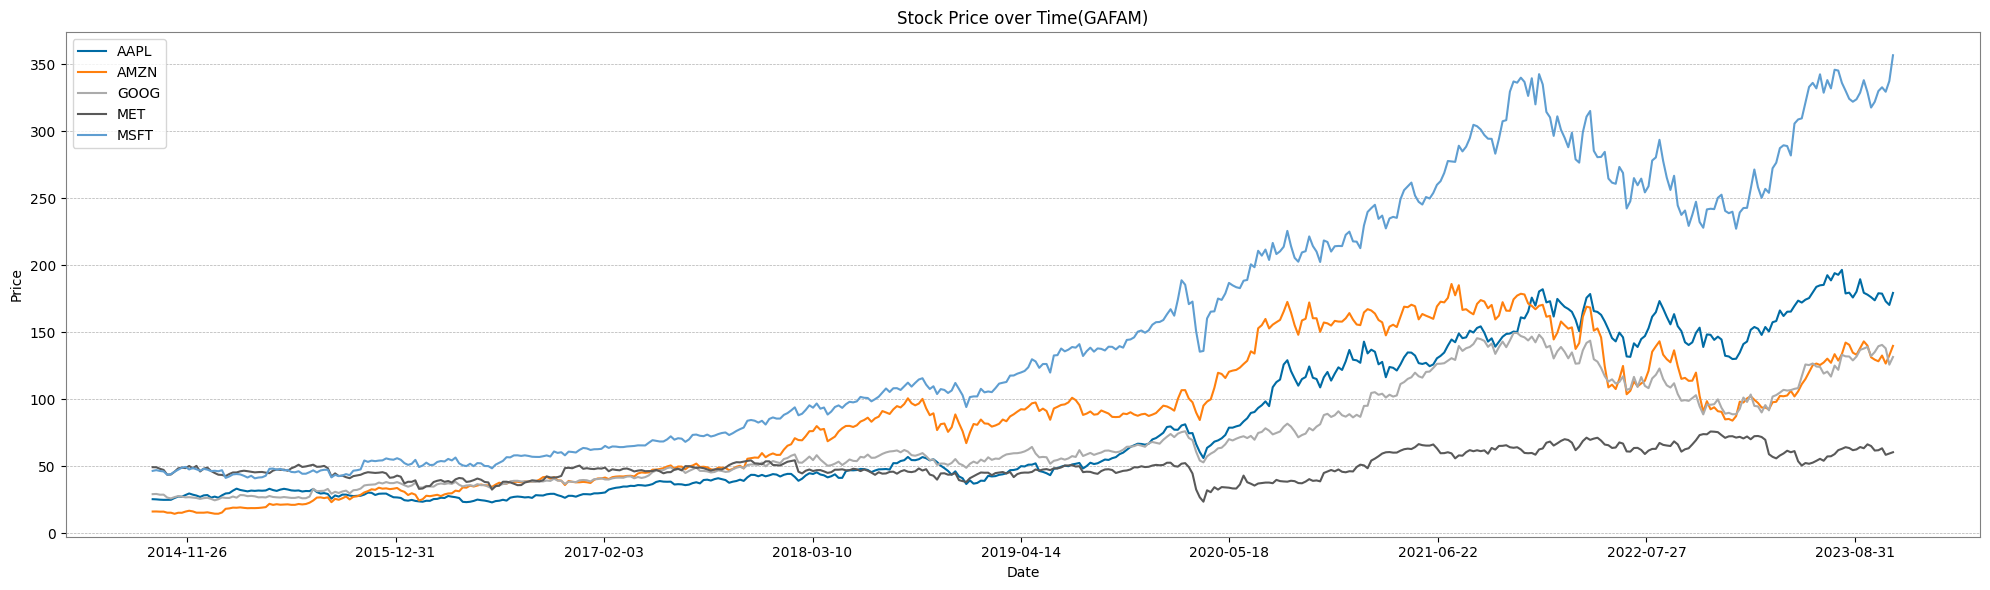

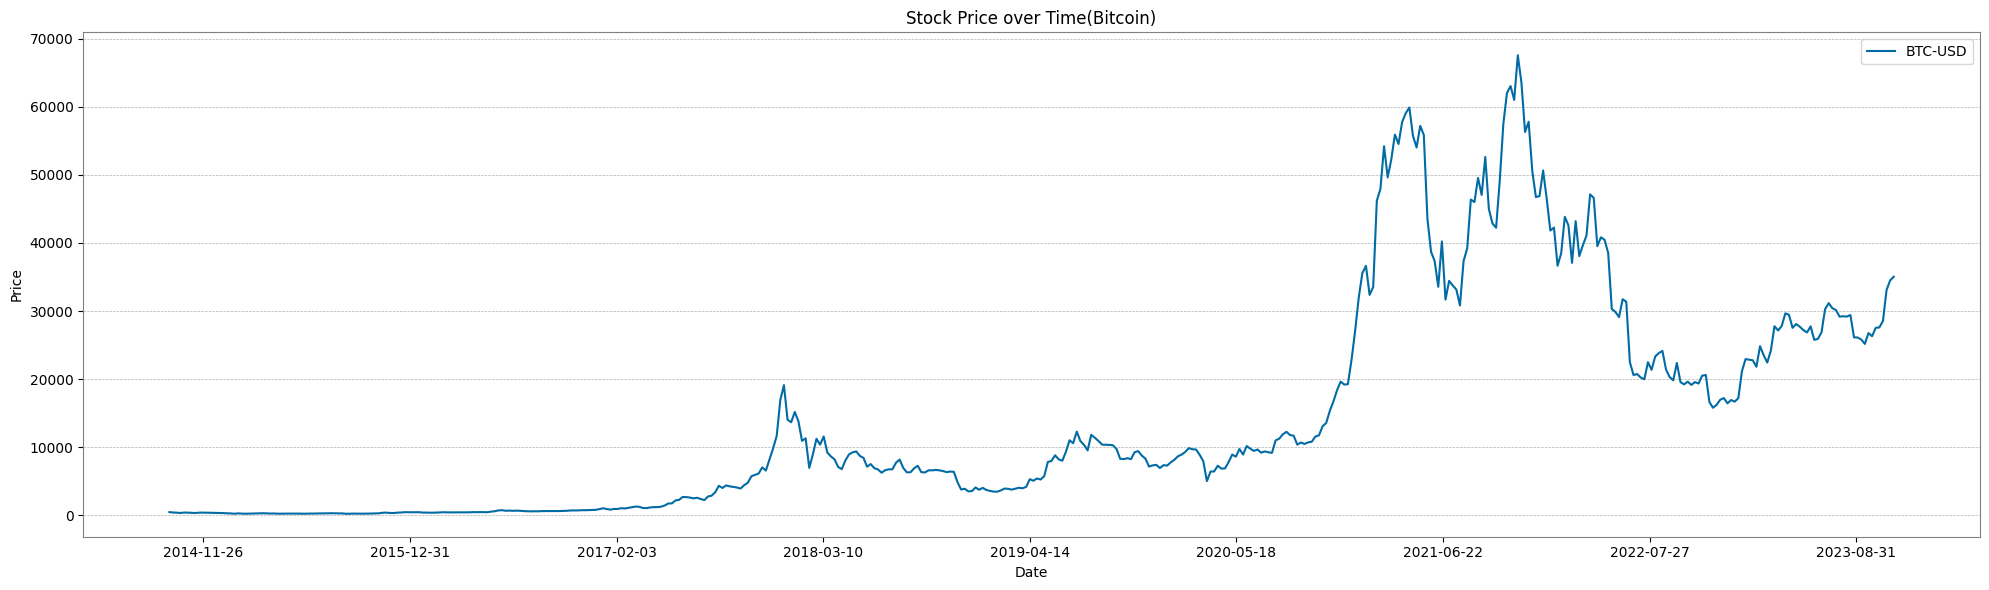

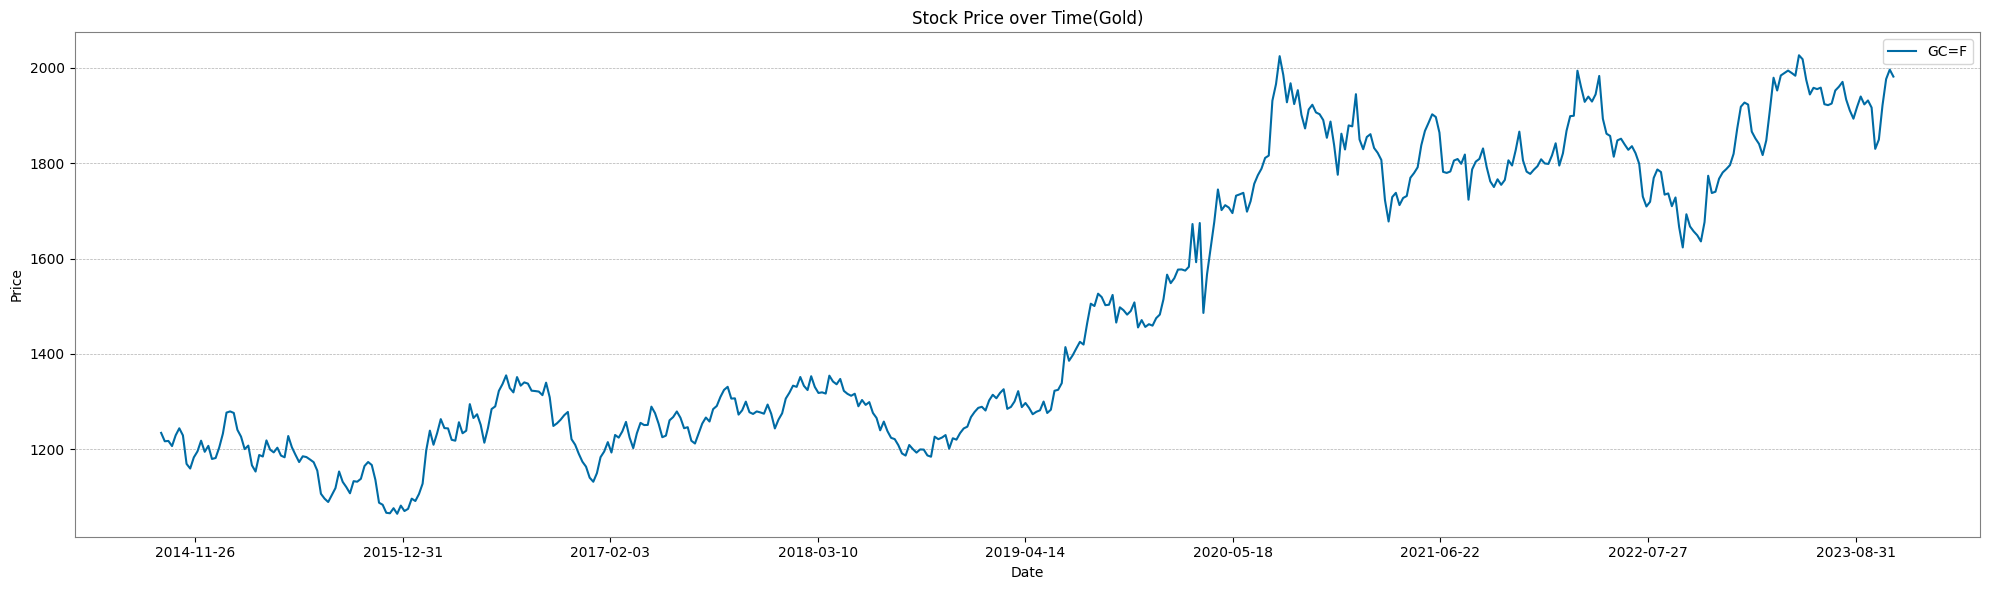

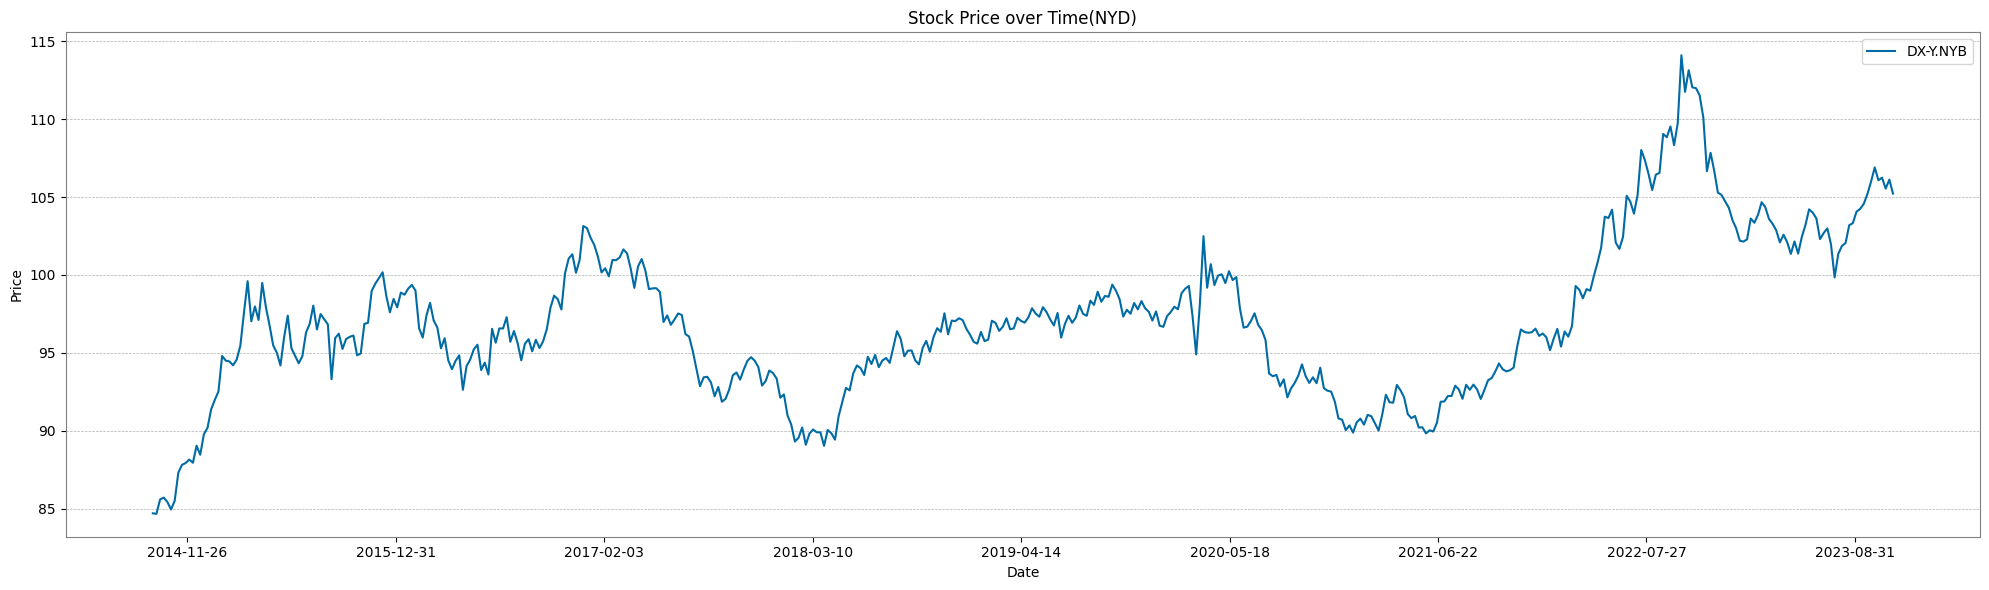

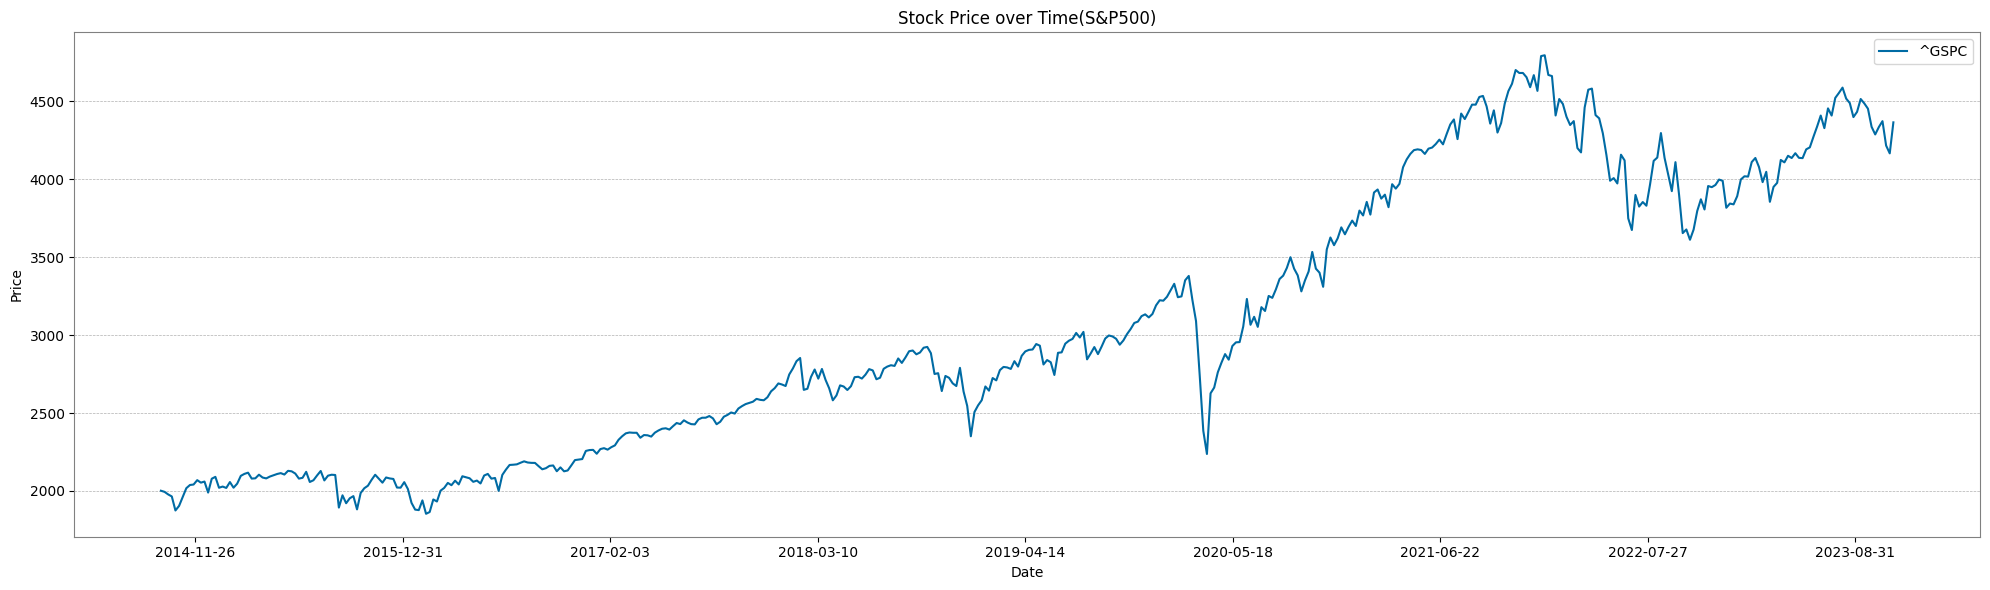

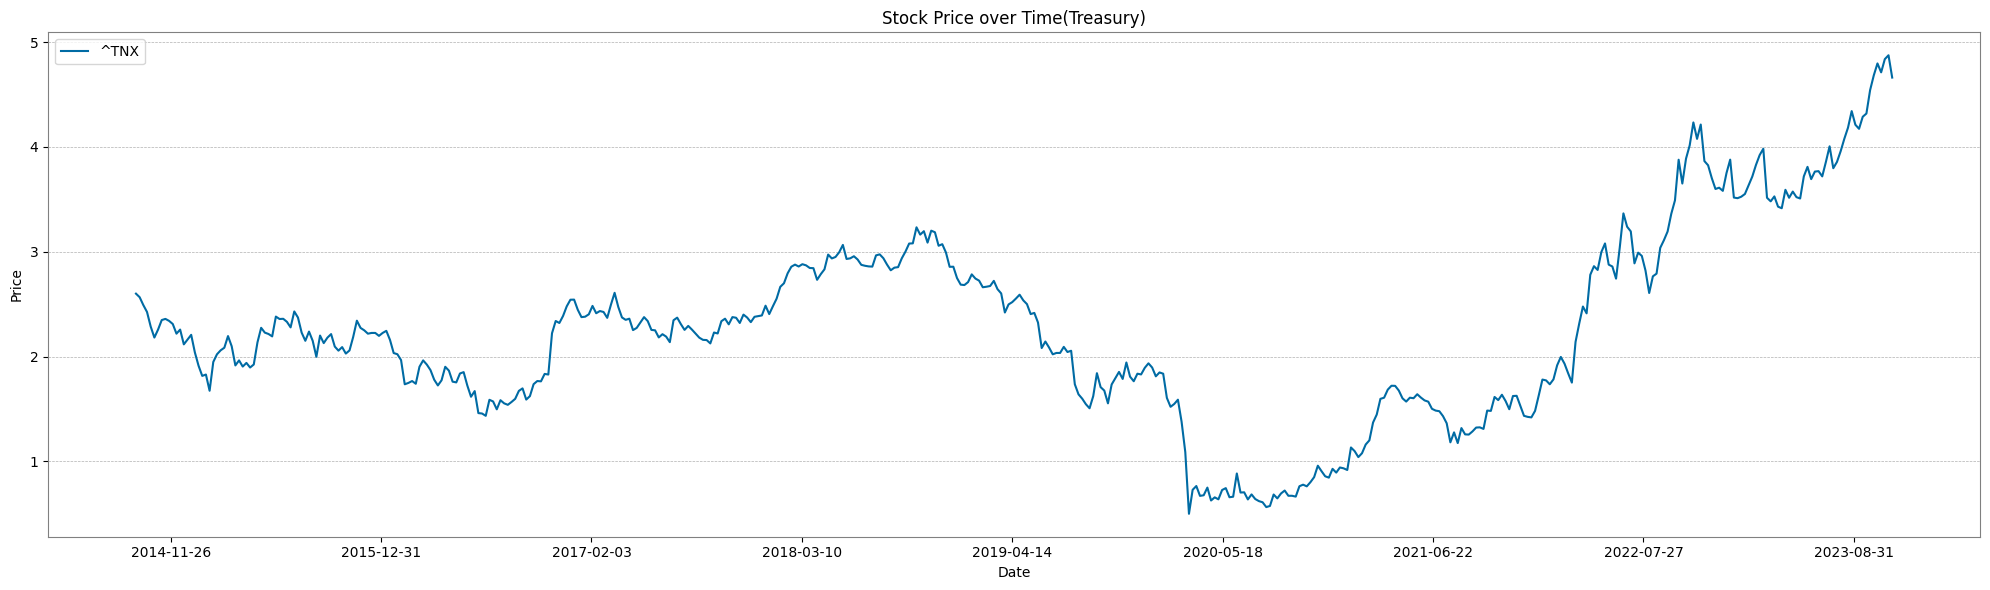

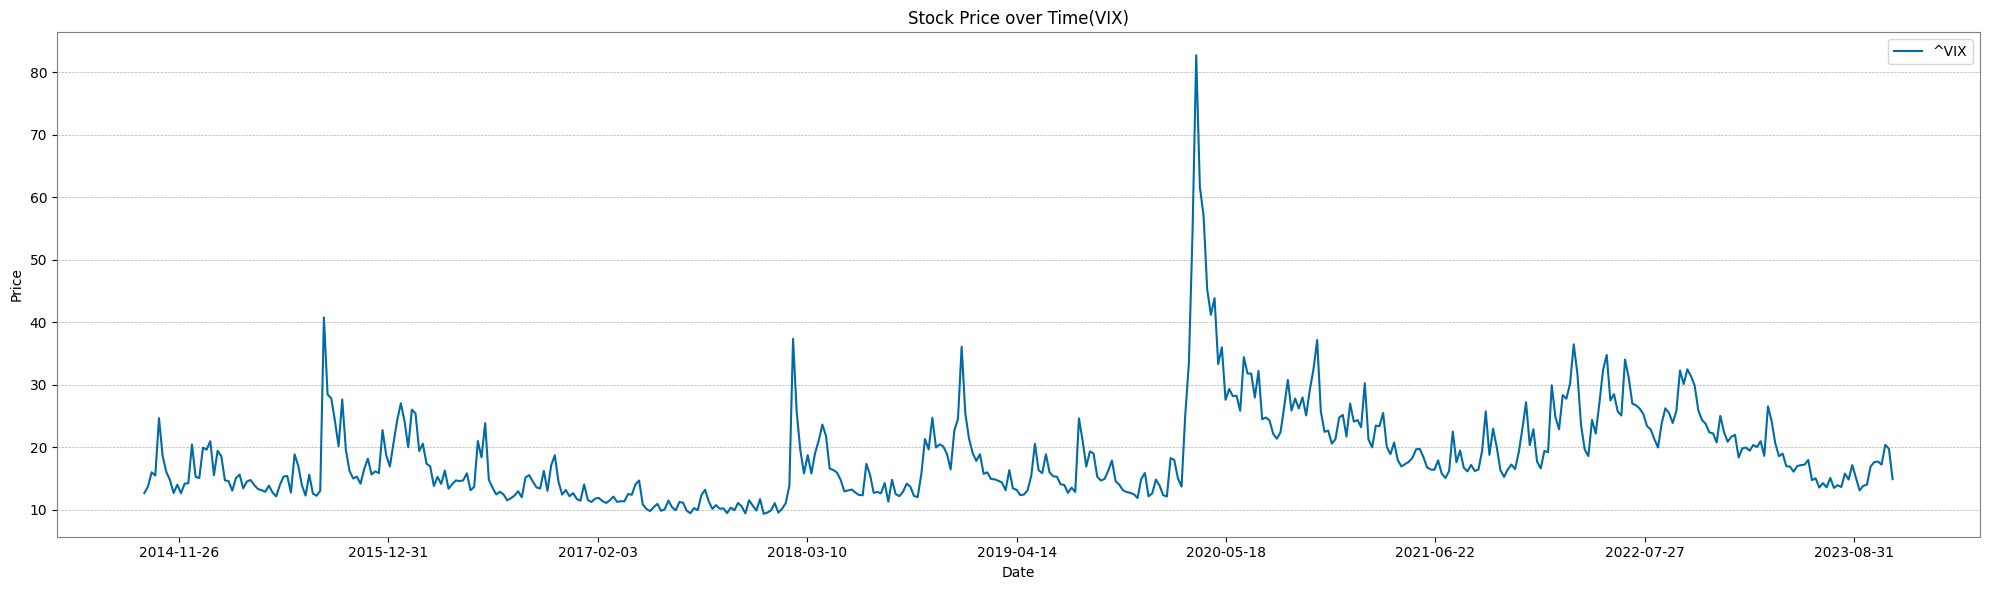

In [71]:
columns_GAFAM = ["AAPL", "AMZN", "GOOG", 'MET', "MSFT", ]
columns_Material = ['GC=F'] # 金
columns_NYD = ['DX-Y.NYB'] # NYD
columns_SP = ["^GSPC"] # S&P500
columns_Tresury = ["^TNX"] # 10年米国債
columns_VIX = ["^VIX"] # CBOE(投資の先行き不安の指数)
columns_Bitcoin = ['BTC-USD']


# GAFAM--------------
plot_stock_prices('GAFAM', df_main, columns_GAFAM)
# Bitcoin--------------
plot_stock_prices('Bitcoin', df_main, columns_Bitcoin)
# Gold--------------
plot_stock_prices('Gold', df_main, columns_Material)
# NYD--------------
plot_stock_prices('NYD', df_main, columns_NYD)
# SP--------------
plot_stock_prices('S&P500', df_main, columns_SP)
# Tresury--------------
plot_stock_prices('Treasury', df_main, columns_Tresury)
# VIX--------------
plot_stock_prices('VIX', df_main, columns_VIX)


## Quantifying the risk of Bitcoin with VAR

In [96]:
# 2. 収益率の計算
# Bitcoinの価格を基に収益率を計算します。ここでは 'Price' 列が価格データを含んでいると仮定しています。
df_main['return_BTC'] = df_main['BTC-USD'].pct_change()

In [97]:
df_main

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX,return_BTC
Date,,,,,,,,,,,,
2014-09-21,25.395000,16.200001,457.334015,84.699997,1234.400024,29.158445,49.269161,46.520000,2001.569946,2.600,12.650000,NaN
2014-09-28,25.264999,16.225000,402.152008,84.669998,1216.800049,29.288090,49.215687,47.060001,1994.290039,2.566,13.690000,-0.120660
2014-10-05,25.027500,16.091000,375.467010,85.589996,1217.500000,28.739098,48.048126,46.439999,1977.800049,2.491,15.980000,-0.066355
2014-10-12,24.905001,16.110001,330.079010,85.709999,1206.699951,28.788462,47.228165,46.090000,1964.819946,2.425,15.460000,-0.120884
2014-10-19,24.952499,15.322500,390.414001,85.430000,1229.300049,26.587503,43.645275,43.650002,1874.739990,2.286,24.639999,0.182790
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-15,178.990005,128.259995,27583.677734,106.080002,1849.500000,139.500000,61.900002,329.820007,4335.660156,4.797,17.700001,0.001921
2023-10-22,178.720001,132.550003,28519.466797,106.239998,1921.099976,140.490005,63.349998,332.640015,4373.629883,4.712,17.209999,0.033925
2023-10-29,173.000000,126.559998,33086.234375,105.540001,1976.300049,137.899994,58.490002,329.320007,4217.040039,4.838,20.370001,0.160128


In [100]:
df_bitcoin = df_main[['BTC-USD', 'return_BTC']]

In [101]:
df_bitcoin

,BTC-USD,return_BTC
Date,,
2014-09-21,457.334015,NaN
2014-09-28,402.152008,-0.120660
2014-10-05,375.467010,-0.066355
2014-10-12,330.079010,-0.120884
2014-10-19,390.414001,0.182790
...,...,...
2023-10-15,27583.677734,0.001921
2023-10-22,28519.466797,0.033925
2023-10-29,33086.234375,0.160128


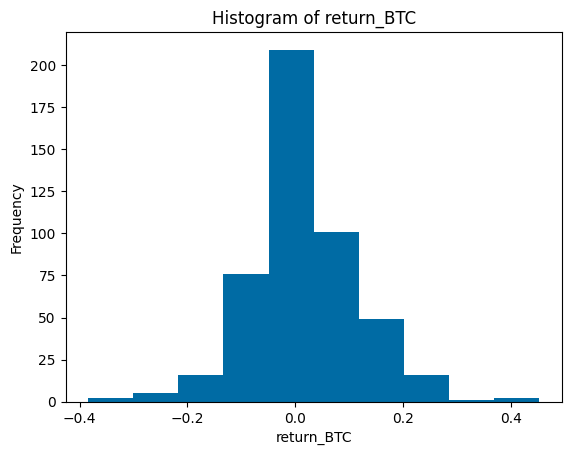

In [103]:
create_histogram(df_bitcoin, 'return_BTC')

In [104]:
evaluate_normality(df_bitcoin['return_BTC'])

Shapiro-Wilk Test: statistic=0.966593861579895, p-value=5.939018610234825e-09
Anderson-Darling Test: statistic=5.049716551951974, significance_level=[15.  10.   5.   2.5  1. ], critical_values=[0.571 0.651 0.781 0.91  1.083]
Kolmogorov-Smirnov Test: statistic=0.08489076101883963, p-value=0.0019375256416727773


In [87]:
df_main

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX,return_BTC
Date,,,,,,,,,,,,
2014-11-23,28.497499,16.152500,387.407990,87.930000,1183.000000,26.752052,48.565063,49.459999,2041.319946,2.340,13.990000,-0.766864
2015-03-01,33.250000,19.007000,238.891998,94.570000,1200.300049,26.522682,45.329769,44.150002,2109.659912,2.059,14.560000,-1.061135
2015-03-08,32.272499,19.283001,275.670013,95.459999,1207.699951,28.488785,46.185383,43.880001,2117.389893,2.084,13.040000,1.964349
2015-03-15,31.785000,18.927999,289.606995,97.589996,1166.400024,28.364626,46.639931,42.849998,2079.429932,2.195,15.060000,-1.113547
2015-03-22,31.237499,18.667500,290.592987,99.599998,1153.300049,27.649588,46.274509,41.560001,2081.189941,2.098,15.610000,-2.697973
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-15,178.990005,128.259995,27583.677734,106.080002,1849.500000,139.500000,61.900002,329.820007,4335.660156,4.797,17.700001,-3.194172
2023-10-22,178.720001,132.550003,28519.466797,106.239998,1921.099976,140.490005,63.349998,332.640015,4373.629883,4.712,17.209999,2.871208
2023-10-29,173.000000,126.559998,33086.234375,105.540001,1976.300049,137.899994,58.490002,329.320007,4217.040039,4.838,20.370001,1.551808


In [88]:
evaluate_normality(df_main['return_BTC'])

Shapiro-Wilk Test: statistic=nan, p-value=1.0
Anderson-Darling Test: statistic=nan, significance_level=[15.  10.   5.   2.5  1. ], critical_values=[0.561 0.639 0.767 0.894 1.064]
Kolmogorov-Smirnov Test: statistic=nan, p-value=nan


## VAR for Bitcoin

In [89]:
df_main

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX,return_BTC
Date,,,,,,,,,,,,
2014-11-23,28.497499,16.152500,387.407990,87.930000,1183.000000,26.752052,48.565063,49.459999,2041.319946,2.340,13.990000,-0.766864
2015-03-01,33.250000,19.007000,238.891998,94.570000,1200.300049,26.522682,45.329769,44.150002,2109.659912,2.059,14.560000,-1.061135
2015-03-08,32.272499,19.283001,275.670013,95.459999,1207.699951,28.488785,46.185383,43.880001,2117.389893,2.084,13.040000,1.964349
2015-03-15,31.785000,18.927999,289.606995,97.589996,1166.400024,28.364626,46.639931,42.849998,2079.429932,2.195,15.060000,-1.113547
2015-03-22,31.237499,18.667500,290.592987,99.599998,1153.300049,27.649588,46.274509,41.560001,2081.189941,2.098,15.610000,-2.697973
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-15,178.990005,128.259995,27583.677734,106.080002,1849.500000,139.500000,61.900002,329.820007,4335.660156,4.797,17.700001,-3.194172
2023-10-22,178.720001,132.550003,28519.466797,106.239998,1921.099976,140.490005,63.349998,332.640015,4373.629883,4.712,17.209999,2.871208
2023-10-29,173.000000,126.559998,33086.234375,105.540001,1976.300049,137.899994,58.490002,329.320007,4217.040039,4.838,20.370001,1.551808


In [110]:
"""
モンテカルロシミュレーションを使用してVaRを計算する関数。

Parameters:
df (DataFrame): 'Price' 列を含む収益率のDataFrame。
initial_price (float): 計算の基準となる初期価格。
confidence_level (float): VaRの信頼水準。
num_simulations (int): シミュレーションの回数。
time_horizon (int): 価格を予測する週数。

Returns:
float: 計算されたVaRの値。
"""
# 使用例:
# df['returns'] = df['Price'].pct_change().dropna()
initial_price = 8000
calculated_var = calculate_var(df_bitcoin, 'return_BTC', initial_price)
print(f"1週間のVaR（信頼水準 {confidence_level * 100}%）: ${calculated_var:.2f}")

KeyError: 'returns'